## Задача-2. Классификации лунок

In [8]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from PIL import Image

import torch
import torch.nn as nn

from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader, Subset


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
# АВТОЭНКОДЕР

class Encoder(nn.Module):
    def __init__(self, input_channels=3, latent_dim=2):
        super(Encoder, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(input_channels, 28, kernel_size=3, stride=2, padding=1), # (14, 14)
            nn.ReLU(True),
            nn.Conv2d(28, 128, kernel_size=3, stride=2, padding=1), # (7, 7)
            nn.ReLU(True),
            nn.Flatten()
        )
        self.linear = nn.Linear(128 * 7 * 7, latent_dim)
        
    def forward(self, x):
        z = self.net(x)
        z = self.linear(z)
        return z
    
class Decoder(nn.Module):
    def __init__(self, input_channels=3, latent_dim=2):
        super(Decoder, self).__init__()
        
        self.linear = nn.Linear(latent_dim, 128 * 7 * 7)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(128, 28, kernel_size=3, stride=2, padding=1, output_padding=1),  # (14, 14)
            nn.ReLU(True),
            nn.ConvTranspose2d(28, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1), # (28, 28)
            nn.Sigmoid()
        )
    
    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 128, 7, 7)
        x = self.net(x)
        return x

    
class AutoEncoder(nn.Module):
    def __init__(self, input_channels=3, latent_dim=2):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(input_channels, latent_dim)
    
    def train(self, data, epochs=20):
        opt = torch.optim.Adam(self.parameters())
        for epoch in range(epochs):
            print(f"Epoch-{epoch + 1}/{epochs}")
            for i, batch in enumerate(data):
                x, _ = batch
                x = x.to(device)
                x_hat = self(x)
                opt.zero_grad()
                loss = ((x - x_hat)**2).sum()
                loss.backward()
                opt.step()
                if i % 1000 == 0:
                    print("\t Loss:", loss.item())
    
    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [28]:
# класс датасета
class CustomDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        """
        Args:
            txt_file (string): Путь к txt-файлу с данными
            root_dir (string): Каталог с изображениями
            transform (callable, optional): Преобразование изображения
        """
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data[idx][0]
        label = int(self.data[idx][1])
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def load_data(self):
        with open(self.txt_file, 'r') as f:
            lines = f.readlines()
        
        data = [line.split() for line in lines]
        return data

In [10]:
# функция по получению выходов энкодера
def get_encoder_ouputs(model, data, limit=500):
    outputs = []
    for i, batch in enumerate(data):
        x, _ = batch
        x = x.to(device)
        z = model.encoder(x)
        outputs.append(z.detach().cpu().tolist()[0])
        if i > limit:
            break
    return np.array(outputs)

# функция по получению ошибки модели на примерах
def get_losses(model, data):
    losses = []
    for i, batch in enumerate(data):
        x, _ = batch
        x = x.to(device)
        x_hat = model(x)
        loss = ((x - x_hat)**2).sum()
        losses.append(loss.detach().cpu().tolist())
    return losses

### Загрузка датасета

In [11]:
transform = v2.Compose([
        v2.Resize((28, 28)),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Grayscale()
])

data_dir = '/kaggle/input/lunki-task/dataset'
data = datasets.ImageFolder(root=data_dir, transform=transform)

In [12]:
idx_train = [i for i in range(len(data)) if data.imgs[i][1] == data.class_to_idx['train']]
idx_proliv = [i for i in range(len(data)) if data.imgs[i][1] == data.class_to_idx['proliv']]

In [13]:
train = Subset(data, idx_train)
train_loader = DataLoader(train, batch_size=1, shuffle = True)
print(len(train))

val = Subset(data, idx_proliv)
val_loader = DataLoader(val, batch_size=1, shuffle = True)

### Обучение модели

In [20]:
latent_dim = 8
input_channels = 1

autoencoder = AutoEncoder(input_channels, latent_dim).to(device)
autoencoder.train(train_loader, epochs=5)

Epoch-1/5
	 Loss: 5.753783226013184
	 Loss: 0.3575259745121002
	 Loss: 0.25165003538131714
	 Loss: 0.188993439078331
	 Loss: 0.3644185960292816
	 Loss: 0.33070462942123413
	 Loss: 0.3137861490249634
	 Loss: 0.4655798673629761
	 Loss: 0.5191192030906677
	 Loss: 0.18708884716033936
Epoch-2/5
	 Loss: 0.23645272850990295
	 Loss: 0.14475443959236145
	 Loss: 0.18255549669265747
	 Loss: 0.13929474353790283
	 Loss: 0.17976272106170654
	 Loss: 0.09622138738632202
	 Loss: 0.203030064702034
	 Loss: 0.17618930339813232
	 Loss: 0.3835054636001587
	 Loss: 0.6247632503509521
Epoch-3/5
	 Loss: 0.1378040611743927
	 Loss: 0.22974732518196106
	 Loss: 0.17664259672164917
	 Loss: 0.16568680107593536
	 Loss: 0.552480936050415
	 Loss: 0.21461790800094604
	 Loss: 0.09159591794013977
	 Loss: 0.11626856029033661
	 Loss: 0.13336621224880219
	 Loss: 0.27212807536125183
Epoch-4/5
	 Loss: 0.1310395747423172
	 Loss: 0.08049464970827103
	 Loss: 0.11999310553073883
	 Loss: 0.08798978477716446
	 Loss: 0.217683240771293

### Визуализация латентного пространства

In [21]:
train_points = get_encoder_ouputs(autoencoder, train_loader)
val_points = get_encoder_ouputs(autoencoder, val_loader)

train_marks = np.zeros(train_points.shape[0])
val_marks = np.ones(val_points.shape[0])

points = np.vstack([train_points, val_points]) 
marks = np.hstack([train_marks, val_marks])

In [22]:
points_2d = UMAP(random_state=1000).fit_transform(points)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/tmp/ipykernel_34/147410534.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", 10), data=df)


<Axes: xlabel='comp-1', ylabel='comp-2'>

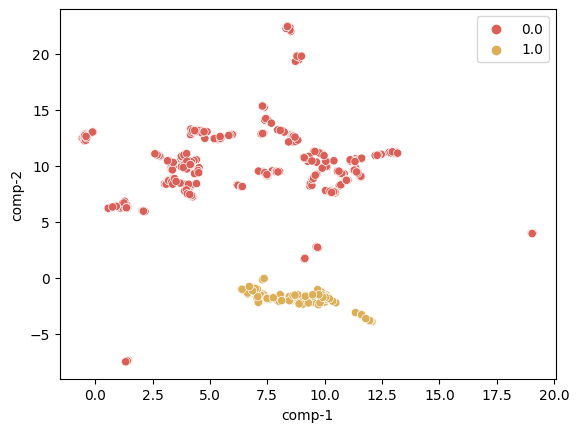

In [23]:
df = pd.DataFrame()
df["y"] = marks
df["comp-1"] = points_2d[:,0]
df["comp-2"] = points_2d[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", 10), data=df)

### Подбор threshold для проливов

In [24]:
train_losses = get_losses(autoencoder, train_loader)
val_losses = get_losses(autoencoder, val_loader)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'MSE distribution')

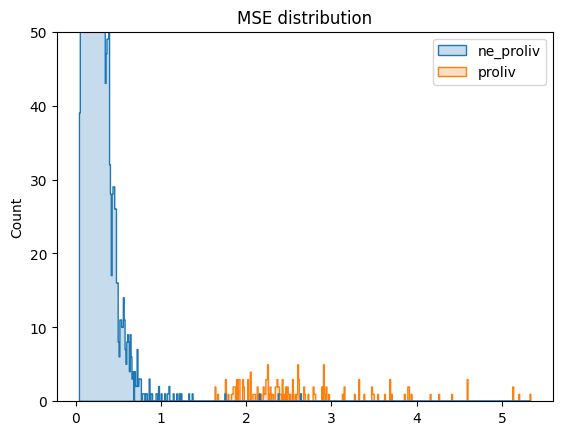

In [25]:
fig, ax = plt.subplots()

hist = sns.histplot([train_losses, val_losses], element="step")
hist.set(ylim=(0, 50));

legend = ax.get_legend()
handles = legend.legend_handles
ax.legend(handles, ['ne_proliv', 'proliv'])
ax.set_title("MSE distribution")

In [26]:
threashold = 1.5

### Классификация проливов

In [29]:
txt_file_path = '/kaggle/input/lunki-task/dataset/test/test_annotation.txt'
root_dir_path = '/kaggle/input/lunki-task/dataset/test/imgs'

test_data = CustomDataset(txt_file=txt_file_path, root_dir=root_dir_path, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [30]:
target_history = []
pred_history = []

for batch_idx, (data, target) in enumerate(test_dataloader):
    x = data.to(device)
    target = int(target)
    x_hat = autoencoder(x)
    loss = ((x - x_hat)**2).sum()
    
    if loss < threashold:
        output = 0
    else:
        output = 1
    
    target_history.append(target)
    pred_history.append(output)
    

predicted_labels = np.array(pred_history)
true_labels = np.array(target_history)

In [32]:
TP = np.sum((predicted_labels == 1) & (true_labels == 1))
TN = np.sum((predicted_labels == 0) & (true_labels == 0))
FP = np.sum((predicted_labels == 1) & (true_labels == 0))
FN = np.sum((predicted_labels == 0) & (true_labels == 1))


TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.0
TNR = TN / (TN + FP) if (TN + FP) > 0 else 0.0

print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")

True Positive Rate (TPR): 0.7907
True Negative Rate (TNR): 0.8442
